In [1]:
import ginsim
import biolqm
from colomoto_jupyter import tabulate
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

try:
    import cobra
except ImportError:
    import sys
    !{sys.executable} -m pip install cobra
    import cobra

cmp = sns.diverging_palette(0, 255, as_cmap=True)

This notebook has been executed using the docker image `colomoto/colomoto-docker:2021-10-01`

# 1. Loading the two models of interest

- The CaSQ-generated CAF-specific boolean model;
- MitoCore constraint-based model of human metabolism.

## 1. 1. Load the CAF-model

In [2]:
CAF_model = biolqm.load("CAF-model.sbml")

The sanitize function is used to generate human-friendly node IDs and rescale the layout to improve the model's readability.


*Note: this cell may take a few minutes to run.*

In [3]:
CAF_model = biolqm.sanitize(CAF_model)

layout = CAF_model.getLayout()
layout.scale(0.4)

lrg = biolqm.to_ginsim(CAF_model)

## 1.2. Load MitoCore 

In [4]:
import logging
cobra.io.sbml.LOGGER.setLevel(logging.ERROR)

MitoCore = cobra.io.read_sbml_model('mitocore_v1.01.xml')

# 2. Value propagation

Definition of several sets of initial conditions adapted from CAF-specific initial conditions. Each component’s value initially set to 1/0 in CAF-specific conditions was alternatively set to 0/1 while the others remained at CAF-specific values.

For technical reasons, the new set of initial conditions was divided in 2 files (Breast_CAF_KO-KI_initial_conditions_1.tsv and Breast_CAF_KO-KI_initial_conditions_2.tsv)

In [5]:
inits = pd.read_csv("Breast_CAF_KO-KI_initial_conditions_1.tsv", sep="\t", index_col=0)
#inits = pd.read_csv("Breast_CAF_KO-KI_initial_conditions_2.tsv", sep="\t", index_col=0)

dic_inits = inits.to_dict()

Definition of some helper functions and color mapping rules to perform value propagation and visualize the result.

In [6]:
# Transforms a dictionary into a dash-like pattern used for space restrictions.
# If a model has 4 components A, B, C, D in this order,
#  {A:0, D:1} => "0--1"

def dash_pattern(model, dict_vals):
    specific_comps = dict_vals.keys()
    str_pattern = ""
    for comp in model.getComponents():
        if comp.toString() in specific_comps:
            str_pattern += str(dict_vals.get(comp.toString()))
        else :
            str_pattern += "-"
    return(str_pattern)

def restrict_model(model, **dict_vals):
    pattern = dash_pattern(model, dict_vals)
    return biolqm.restrict(model, pattern)

def fill_fixed(data, names, functions, mddman):
    all_values = [f for f in functions]
    for comp, func in zip(names, functions):
        if mddman.isleaf(func): data[comp] = func
        else: data[comp] = -1
    

def get_fixed_pattern(all_names, model, as_dict=False):
    # Build a container for the results
    pattern = {key: 100 for key in all_names}
    
    # Model manager and core components
    mddman = model.getMDDManager()
    core_components = [node.getNodeID() for node in model.getComponents()]
    extra_components = [node.getNodeID() for node in model.getExtraComponents()]
    
    # 1/ Non-extra values: if the model was not reduced, core components may also contain fixed values
    fill_fixed(pattern, core_components, model.getLogicalFunctions(), mddman)
    
    # 2/ Extra values : only available after reduction/percolation
    # Functions of each component
    fill_fixed(pattern, extra_components, model.getExtraLogicalFunctions(), mddman)

    if as_dict: return pattern
    return pd.Series(pattern, dtype=np.byte)

def get_fixed(gs_model, restricted_model, as_dict=False):
    name_components = [ n.getId() for n in gs_model.getNodeOrder() ]
    return get_fixed_pattern(name_components, restricted_model, as_dict)

def show_fixed(gs_model, styler, fixed_pattern, save=None):
    styler.setState(fixed_pattern.values.tobytes())
    return ginsim.show(gs_model, style=styler, save=save)


# Define color mapping rules
styler_fixed = ginsim.lrg_style(lrg)
styler_fixed.mapState2Color(0, 255, 255, 255)
styler_fixed.mapState2Color(1, 100, 100, 255)
styler_fixed.mapState2Color(-1, 255, 100, 100)

In [7]:
data = []

for init_name, values in dic_inits.items():
    lqm_model_restricted = restrict_model(CAF_model, **values)
    data.append( get_fixed(lrg, lqm_model_restricted) )
    
df = pd.concat(data, axis=1, keys=[name for name in dic_inits])

The result of value propagation can be visualized in the following heatmap where each line represents a component of the system and the column represent the input condition. 
    
- A **white cell** denotes that the corresponding component is **fixed at 0** by value propagation in this input condition;
- A **blue cell** denotes that the corresponding component is **fixed at 1** by value propagation in this input condition;
- A **red cells** denote components **which are not fixed** by value propagation in this input condition.

<AxesSubplot:>

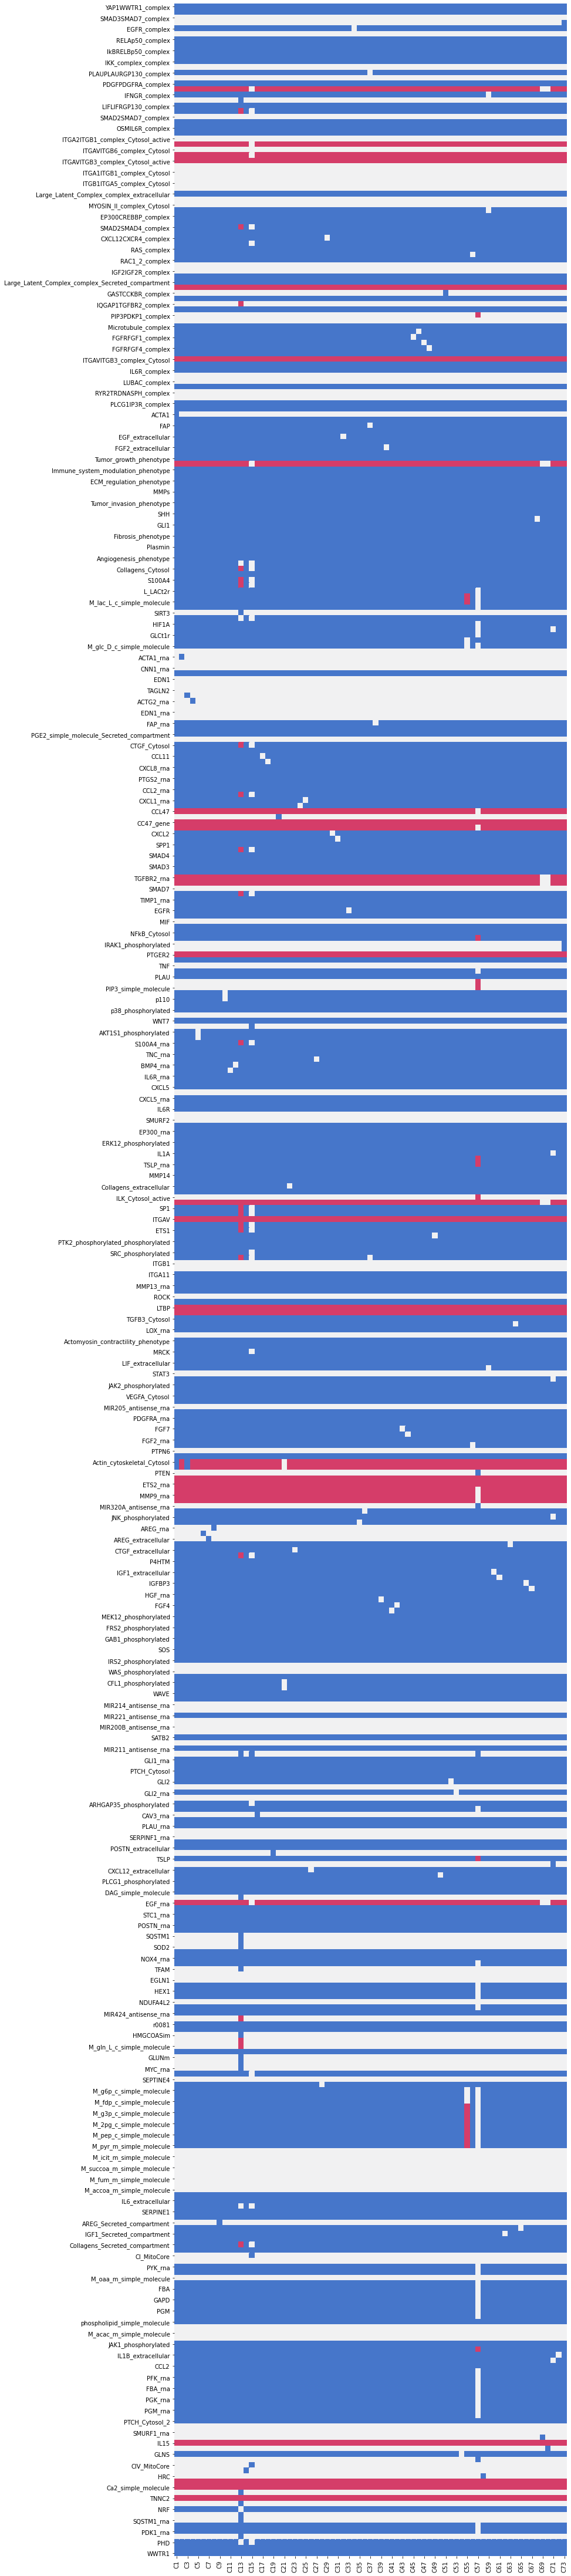

In [8]:
plt.figure(figsize=(12,80))

sns.heatmap(df, center=0, cmap=cmp, cbar=False)

# 3. Extracting common metabolic enzymes and metabolites between the CAF-Model and MitoCore

The common metabolic compounds will allow to project the trapspaces calculated afterwards on the latter.

In [9]:
MitoCore_Enzymes = [r.id for r in MitoCore.reactions]

MitoCore_Metabolites = [m.id for m in MitoCore.metabolites]

In [10]:
intermediates = ["atp_c", "adp_c", "adn_c", "adp_m", "amp_c", "amp_m", "atp_m", "cdp_m", "cmp_c", "co_c", "co_e",
                 "co2_c", "co2_e", "co2_m", "coa_c", "coa_m", "ctp_c", "fe2_c", "fe2_e", "fe2_m", "ficytC_c",
                 "ficytC_e", "ficytC_m", "gdp_c", "gdp_m", "gtp_c", "gtp_m", "h_c", "h_e", "h_m", "h2o_c", "h2o_m",
                 "h2o2_c"," h2o2_m", "hco3_c", "hco3_e", "hco3_m", "nad_c", "nad_e", "nad_m", "nadh_c", "nadh_e",
                 "nadh_m", "nadp_c", "nadp_m", "nadph_c", "nadph_m", "no_c", "no_e", "o2_c", "o2_e", "o2_m", "o2s_m",
                 "pheme_c", "pheme_m", "pi_c", "pi_e", "pi_m", "q10_m", "q10h2_m"]

# 4. Regulatory knock-out/knock-in simulations

For each set of initial conditions, metabolic compounds-associated regulatory trap-spaces’ identification and extraction of metabolic constraints are conducted to perform subsequent FBA and evaluate metabolic fluxes’ distribution. 
MitoCore model is loaded in each iteration to not pursue the analysis with the constraints identified and applied to MitoCore in the previous iteration.

The percentage of cellular ATP production from glycolysis for each set of initial conditions is stored in the "results" dataframe.


In [11]:
results = []

for column in df:
    condition = df[column].loc[lambda x : x>=0]
    string = condition.index.map(str) + "%" + condition.map(str)
    string = string.reset_index(drop=True)
    pert = list(string)
    perturbations = " ".join(pert)
    
    MitoCore = cobra.io.read_sbml_model('mitocore_v1.01.xml')
    CAF_model_perturbated = biolqm.perturbation(CAF_model, perturbations)
    
    trapspaces = biolqm.trapspace(CAF_model_perturbated)
    trapspaces_df = pd.DataFrame(trapspaces)
    trapspaces_df.columns = (trapspaces_df.columns.str.replace("_complex", "")
                             .str.replace('_phosphorylated','')
                             .str.replace("_Cytosol","")
                             .str.replace('_simple_molecule', '')
                             .str.replace('_active', '')
                             .str.replace('M_', '')
                             .str.replace('_rna','')
                             .str.replace('_antisense','')
                             .str.replace('_Nucleus','')
                             .str.replace('_empty','')
                             .str.replace('_extracellular','')
                             .str.replace('_Secreted_compartment', '')
                             .str.replace('_space','')
                             .str.replace('_Mitochondrion_outter_mb','')
                             .str.replace('_Mitochondrion_inner_mb',''))
    
    CAF_model_components = trapspaces_df.columns.values
    
    common_enzymes = list((set(CAF_model_components).intersection(MitoCore_Enzymes)))
    common_metabolites = list(set(CAF_model_components).intersection(MitoCore_Metabolites)-set(intermediates))
    
    trapspaces_metabolic_enzymes = trapspaces_df[common_enzymes]
    trapspaces_metabolites = trapspaces_df[common_metabolites]
    
    trapspaces_metabolic_enzymes_zero = trapspaces_metabolic_enzymes.loc[:,(trapspaces_metabolic_enzymes.max(axis=0)) == 0]
    enzymes_to_zero = trapspaces_metabolic_enzymes_zero.columns.values.tolist()
    
    trapspaces_metabolites_zero = trapspaces_metabolites.loc[:,(trapspaces_metabolites.max(axis=0)) == 0]
    metabolites_to_zero = trapspaces_metabolites_zero.columns.values.tolist()
    metabolite_to_zero = []
    for i in metabolites_to_zero:
        metabolite_to_zero1 = MitoCore.metabolites.get_by_id(i).summary().producing_flux.index.values.tolist()
        metabolite_to_zero = metabolite_to_zero + metabolite_to_zero1
        
    for i in metabolite_to_zero:
        MitoCore.reactions.get_by_id(i).lower_bound = 0
        MitoCore.reactions.get_by_id(i).upper_bound = 0
        
    for i in enzymes_to_zero:
        MitoCore.reactions.get_by_id(i).lower_bound = 0
        MitoCore.reactions.get_by_id(i).upper_bound = 0
                
    MitoCore.objective = ["PYK", "PGK", "CV_MitoCore"]
                
    solution = MitoCore.optimize()
    ATP_glycolysis = ((solution.fluxes['PYK'] + solution.fluxes['PGK'])/(solution.objective_value))*100
    
    results.append(ATP_glycolysis)

<ipython-input-11-0db73b5653a6>:60: RuntimeWarning: invalid value encountered in double_scalars
  ATP_glycolysis = ((solution.fluxes['PYK'] + solution.fluxes['PGK'])/(solution.objective_value))*100


In [12]:
results_df = pd.DataFrame(results)
results_df.columns = ['Glycolysis (%)']

results_df

,Glycolysis (%)
0,85.054551
1,85.054551
2,85.054551
3,85.054551
4,85.054551
...,...
68,85.054551
69,85.054551
70,85.054551
71,85.054551


In [13]:
results_df.to_csv("FBA_results_CAF_regukatory_KO-KI_1.csv")
#results_df.to_csv("FBA_results_CAF_regukatory_KO-KI_2.csv")  